In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from utils.report import *

# Sensing passengers by wifi probe requests

_by Miguel Ribeiro, Bernardo Galvão_


**Content**
- data
  - wifi signal measurements
  - ground truth ticket counting
  - data sources join
- raw sensor performance
- data characteristics
- model training
- cross validation results
  - per `route&bus_id`
- final model
- conclusions

---
## data

### wifi signal measurements

Wifi probe detection can entail several radiuses of detection in terms of distance. To address this matter, RSSI (Received Signal Strength Indication) is used as a proxy to distance. The wifi card used for sensing probe requests has an RSSI range of -128 (weakest signal) to 0 (strongest signal). The following are the preset signal features collected:

|variable name|rssi signal $s$&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|---|---|
|`wifi`|$0>s>-128$|
|`wifi_75`|$0>s>-75$|
|`wifi_70`|$0>s>-70$|
|...|...|
|`wifi_45`|$0>s>-45$|

Thus, `count` denotes longest radius in distance and `count_45` denotes shortest radius in terms of detecting wifi enabled devices.

### categorical features

In an attempt to enrich the dataset with potentially useful features, categorical features are one-hot encoded. These categorical features included are:
- `bus_id`
- `hour`
- `month`

### ground truth ticket counting

Ground truth data is provided by Horários do Funchal as number of validated tickets (which includes passes) per hour.

### data sources join

|source|#data points|first data point|last data point|
|---|---|---|---|
|wifi sensor readings|1596|2018-09-30 17:00:00|2019-01-17 17:00:00|
|tickets ground truth|10294|2017-01-01 00:00:00|2019-01-17 22:00:00|

The above table describes the quantity of data available for this analysis, for all the bus routes and buses (`bus_id`). There is a considerable inferior amount of data points available for the wifi sensor readings; that which we wish to evaluate the suitability to measure the amount of passengers at any given time. No data imputation for these readings is performed because:
1. it would mean guessing ~85% of the wifi readings, extrapolating from a minority of data
2. the desirable precision of wifi readings is highly vulnerable to:
  1. wifi hotspots outside the bus
  2. events
  3. hardware status
  
To illustrate point 1.B:

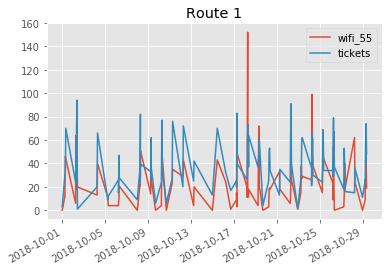

In [7]:
df.dropna().set_index(['route', 'datetime']).loc[1][['wifi_55', 'tickets']].loc[:'2018-10-29'].plot(
    title='Route 1'
); plt.xlabel('');

In [8]:
meta_feature = 'route'
df.groupby(meta_feature).tickets.count().to_frame().join(df.groupby(meta_feature).wifi.count()).transpose()

route       1     2   3     4  8  9   10   12   13  14  ...   38  39  42  44  \
tickets  1673  1245  76  1595  2  2  111  621  768  13  ...   97  39   2  83   
wifi      283   141  27   141  0  1    8   87   81   0  ...   38   1   0  23   

route     45   47   48   49  36A    ND  
tickets  401  285  845  292    8  1088  
wifi     159   52  132  123    1   160  

[2 rows x 26 columns]

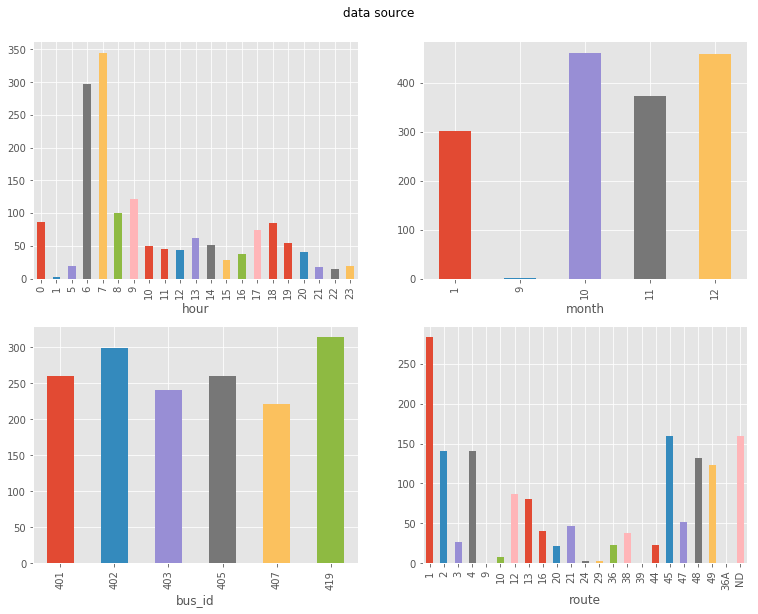

In [9]:
plot_categorical_value_counts_barplots()

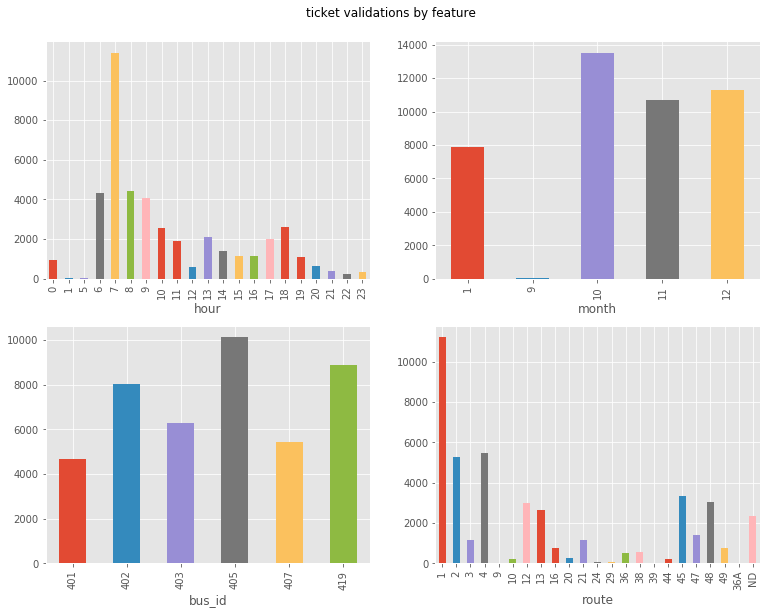

In [10]:
plot_groupby_count_tickets()

The following tables take into account the different bus routes and buses.

In [11]:
rb_ticket_validations = df.groupby(['route', 'bus_id']).tickets.sum().unstack(-1)  # ticket validations

rb_data_count = df.groupby(['route', 'bus_id']).tickets.count().unstack(-1)  # data sources
#rb_data_count.style.background_gradient(cmap='viridis')
rb_data_count['total'] = rb_data_count.sum(axis=1); rb_data_count.loc['total'] = rb_data_count.sum()

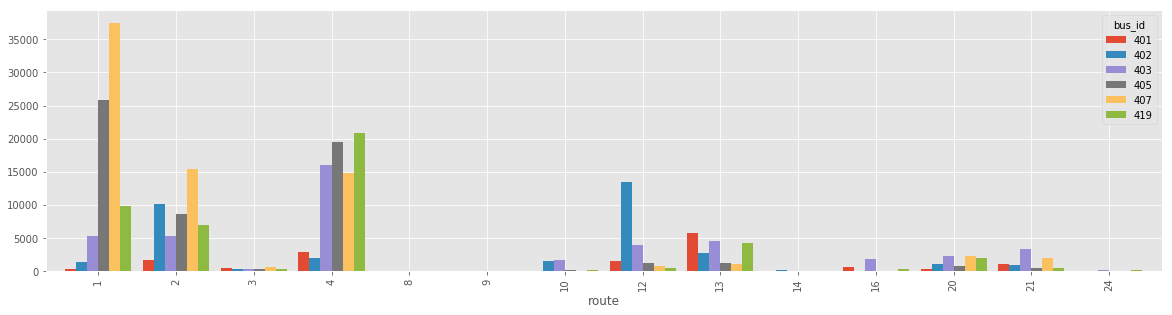

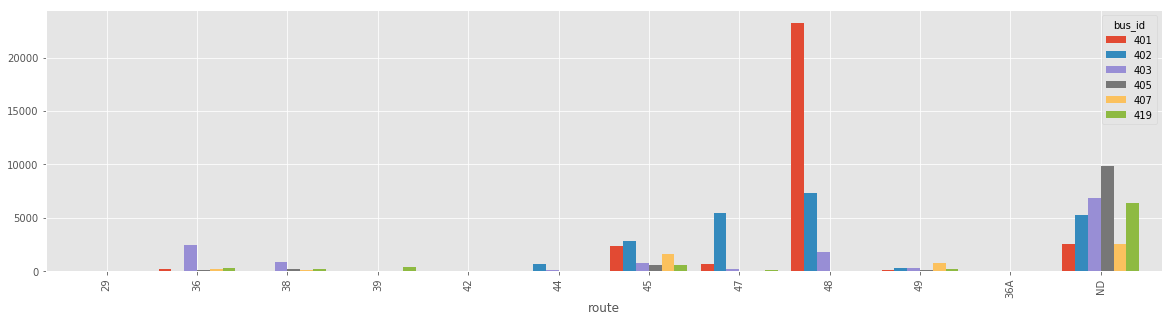

In [12]:
rb_ticket_validations.iloc[:14].plot.bar(figsize=(20, 4.8), logy=False, width=.85)
rb_ticket_validations.iloc[14:].plot.bar(figsize=(20, 4.8), logy=False, width=.85)

---

## raw sensor performance

This section attempts to answer how the wifi sensors perform in approximating the number of passengers. As there are different signal "radiuses" (from `wifi_45` to `wifi`), the first step is to determine which signal is closest to the ground truth data. For this purpose, the root mean square error metric is utilized.

In [13]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

df.dropna().set_index([
    'route', 'datetime'
]).sort_index()[wifi_cols+target].reset_index().groupby(
    'route'
).corr()[
    wifi_cols
].swaplevel().loc['tickets'].dropna(
).transpose().style.apply(highlight_max)

d = df.dropna().set_index(['route', 'datetime']).sort_index()[
    wifi_cols + target
]
routes = d.index.levels[0]
res = pd.DataFrame(index=routes, columns=wifi_cols)
for route in routes:
    dd = d.loc[route]
    for signal in wifi_cols:
        res.loc[route, signal] = dtw(dd[signal], dd['tickets'])
res.transpose().style.apply(highlight_min)

In [14]:
meta='route'

#rmse
d = df.dropna().set_index([meta, 'datetime']).sort_index()[
    wifi_cols + target
]
routes = d.index.levels[0]
rmse = pd.DataFrame(index=routes, columns=wifi_cols)
for route in routes:
    dd = d.loc[route]
    for signal in wifi_cols:
        rmse.loc[route, signal] = np.sqrt(np.mean((dd[signal]-dd['tickets'])**2))

In [15]:
rmse.style.apply(highlight_min, axis=1)

In [16]:
i2s = {i: j for i, j in enumerate(rmse.transpose().index)}  # int to signal
argminer = lambda row: i2s[row.values.argmin()]
argmaxer = lambda row: i2s[row.values.argmax()]

#argminer(res.loc[1], i2s)
rmse['argmin'] = rmse.agg(argminer, axis='columns')
rmse

wifi  wifi_40  wifi_45  wifi_50  wifi_55  wifi_60  wifi_65  wifi_70  \
route                                                                           
1      629.006  42.5151  38.6066  33.6722  28.5937  31.4203   52.239  91.2736   
2      975.751  43.3966  41.2046  37.6456    34.28  39.2614  62.2207  108.011   
3      590.623  49.0989   48.398  47.6212  45.9823  45.9138  54.1938  76.5855   
4      1506.09  44.9428  42.0352  37.7479  38.6797   61.447  106.096  173.448   
9            2        5        5        5        5        5        4        4   
10     251.411  34.8533  33.0454  32.0546  29.7616  23.6247  16.9963  22.6467   
12     1374.61  43.0099   40.308  38.5616  45.9848  75.1804   130.51  224.207   
13     3875.11  37.5008  35.2788  49.5627   98.354  188.327  339.921  551.902   
16     220.166  23.2067  21.3817  18.5822  16.7108  17.9854  24.8334  35.4168   
20     387.245  17.9633  17.6081  17.0787  15.8372  16.4704  19.4024  31.1769   
21      5742.9  26.4599  27.7013   60.978  141.794  273.894   492.43  797.742   
24     828.884  16.4317  8.20569  12.2746  26.1661  44.6356  83.0301  146.165   
29     626.075  23.3809  23.7276  33.3517  57.8821  84.3564  108.963  150.719   
36     460.404  26.6784   25.378  24.1859  21.8841  21.3358  30.3179  58.3218   
38     327.672  17.0271  16.2707  15.2359  17.1072  23.1795  33.0335   48.188   
39         427       10        1        9       22       37       60       88   
44     544.268  7.06799   5.8384   8.1026  25.4165  57.3248   97.189  143.182   
45     434.343  25.7439  24.1088  22.2634  22.3199  30.2096  47.8091  72.9733   
47     769.778  32.3835  30.7987  27.9116  25.2921  30.5781   50.163  86.0298   
48     420.935  26.3063  24.0922   20.517  19.5926  31.9646  53.1393  82.3449   
49     1658.97  10.8632  14.3807  26.1251  46.6269  89.9227  156.249  247.219   
36A        751       22       20       16       11        3       30       93   
ND     541.864  21.5228  20.2878  19.2458  20.9935  29.6367  46.6346  70.2751   

       wifi_75   argmin  
route                    
1      152.517  wifi_55  
2      190.828  wifi_55  
3      116.426  wifi_60  
4      285.053  wifi_50  
9            4     wifi  
10     43.6377  wifi_65  
12      377.62  wifi_50  
13     872.191  wifi_45  
16     53.1768  wifi_55  
20        52.1  wifi_55  
21     1255.73  wifi_40  
24     237.851  wifi_45  
29     189.734  wifi_40  
36     108.932  wifi_60  
38     69.2056  wifi_50  
39         140  wifi_45  
44     193.768  wifi_45  
45     106.727  wifi_50  
47     144.542  wifi_55  
48     118.249  wifi_55  
49     386.408  wifi_40  
36A        193  wifi_60  
ND     111.308  wifi_50

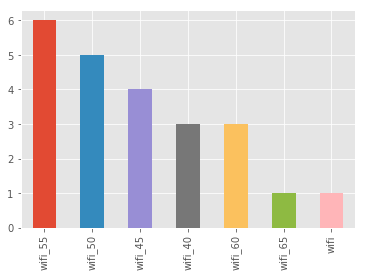

In [17]:
rmse.argmin.value_counts().plot.bar()

In [18]:
meta='route'

#rmse
d = df.dropna().set_index(['route', 'bus_id', 'datetime']).sort_index()[
    wifi_cols + target
]
routes = d.index.levels[0]
rmse = pd.DataFrame(columns=wifi_cols+['bus_id', 'route'])
for route in routes:
    dd = d.loc[route]
    bus_ids = [dd.index for signal in wifi_cols]
    for bus_id in bus_ids:
        for signal in wifi_cols:
            rmse.loc[route, signal] = np.sqrt(np.mean((dd[signal]-dd['tickets'])**2))

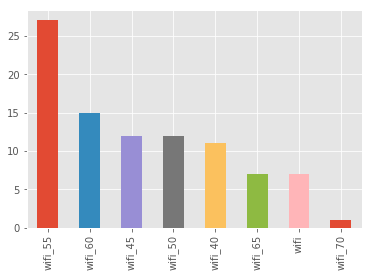

In [19]:
from itertools import product
rmse = lambda preds, targets: np.sqrt(np.mean((preds - targets)**2))
rbid = list(product(df.route.unique(), df.bus_id.unique()))
d = df.dropna().set_index(['route', 'bus_id'])

res = []
for rota, ide in rbid:
    dd = 'banana'
    try:
        dd = d.loc[rota].loc[ide]
    except:
        continue
    res.append([rota, ide] + [rmse(dd[signal], dd['tickets']) for signal in wifi_cols])
    
res = pd.DataFrame(res, columns=['route', 'bus_id']+wifi_cols).set_index(['route', 'bus_id']).sort_index()
res['argmin'] = res.agg(argminer, axis='columns')
res.argmin.value_counts().plot.bar()

## data characteristics

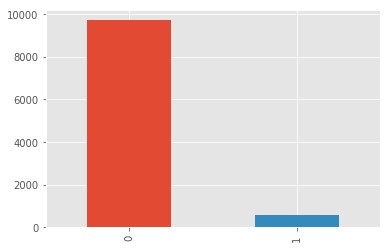

In [20]:
dummy_df = reorder_cols(pd.get_dummies(df, columns=['route', 'bus_id', 'hour', 'month']))
dummy_df['hour_20'].value_counts().plot.bar()

In [21]:
from ipywidgets import interact

@interact(feature=non_target(dummy_df.drop('datetime', axis=1)))
def describe(feature):
    print(dummy_df[feature].describe())
    if 'wifi' in feature:
        dummy_df[feature].plot.hist(bins=50)
    else:
        dummy_df[feature].value_counts().plot.bar()

interactive(children=(Dropdown(description='feature', options=('wifi', 'wifi_40', 'wifi_45', 'wifi_50', 'wifi_…

In [24]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
#model = DecisionTreeRegressor()
model = RandomForestRegressor(1000)



dna = dummy_df.drop('datetime', axis=1).dropna().copy()
top_var = 'placeholder'

input_features = non_target(dummy_df)[1:]

y = dna.tickets
x = dna[input_features]
model.fit(x, y)
dna['pred'] = model.predict(x)
print(r2_score(y, model.predict(x)))
feature_importances = pd.DataFrame(
    index=input_features,
    columns=['feature importance'],
    data=model.feature_importances_
).sort_values('feature importance', ascending=False).head()
top_var = feature_importances.iloc[0].name

dna = dna.join(df.dropna()[['route', 'bus_id', 'datetime']])

feature_importances

0.9288609291129764


feature importance
wifi_75             0.152160
wifi                0.116491
wifi_70             0.075960
route_49            0.048924
wifi_65             0.034249

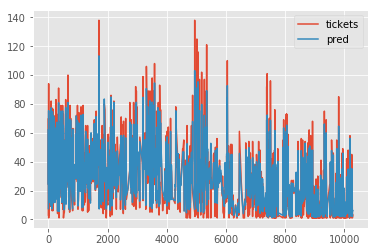

In [25]:
dna[['tickets', 'pred']].plot()

False


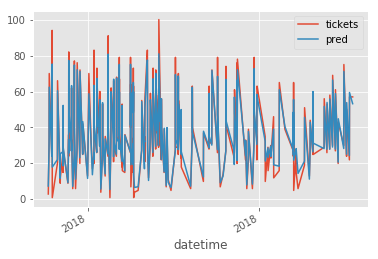

In [55]:
dt = pd.to_datetime
test = ds[ds.datetime.map(lambda date: date.day) != 29].copy()
test['day'] = test.datetime.map(lambda x: x.day)
print(29 in test.day.unique())
test.set_index('datetime')[['tickets', 'pred']].plot(xticks=[dt('2018-10-15 00:00:00'), dt('2018-12-15 00:00:00')])

In [40]:
meta = 'route'
ds='lal'

@interact(meta_i=dna.reset_index()[meta].unique())
def do(meta_i):
    global ds
    ds = dna.set_index(meta).loc[meta_i]
    r2 = r2_score(ds.tickets, model.predict(ds[input_features]))
    print("[" + meta + " " + str(meta_i) + "] :: R2 -> " + str(round(r2, 3)) + " :: " + str(ds.shape[0]) + " samples")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4.8))
    ds[ds.datetime.map(lambda date: date.day) != 29].set_index('datetime').sort_index()[['tickets', 'pred']].plot(ax=axes[0])
    ds.plot.scatter('pred', 'tickets', ax=axes[1])
    #ds.plot.scatter(top_var, 'tickets', ax=axes[2])

interactive(children=(Dropdown(description='meta_i', options=(1, 2, 3, 4, 9, 10, 12, 13, 16, 20, 21, 24, 29, 3…

In [42]:
[i for i in range(100, 1100, 300)]

[100, 400, 700, 1000]

In [38]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [44]:
[i for i in range(10, 70, 10)]

[10, 20, 30, 40, 50, 60]

In [20]:
# meta
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


x = dna[input_features]
y = dna['tickets']

pipeline = Pipeline(
    steps = [
        #('scaler', StandardScaler()),
        #('pca', PCA()),
        ('predictor', RandomForestRegressor())
    ],
    memory=None  # optional caching
)

search_space = [
    #{'scaler': [StandardScaler()], 'scaler__with_mean': [True, False], 'scaler__with_std': [True, False]},
    #{'scaler': [MinMaxScaler()]},
    #{'pca': [PCA(2), PCA(3), PCA(4)]},
    {
        'predictor': [RandomForestRegressor()],
        'predictor__n_estimators': [i for i in range(100, 1100, 300)],
        'predictor__max_features': [i for i in range(10, 70, 10)] + [67]
    }
]

shuffle_and_split = ShuffleSplit(
    n_splits=3,
    test_size=.3,
    #random_state=123
)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=search_space,
    scoring='neg_mean_squared_error',
    cv=shuffle_and_split,
    n_jobs=4,
    iid=False,
    verbose=1
)

gs = gs.fit(x, y)
model = gs.best_estimator_  # best model (or Pipeline, in this case)
dna['pred'] = model.predict(x)
dna['predf'] = dna.pred.map(lambda x: np.floor(x).astype(int))
dna['diff'] = dna.predf - dna.tickets
dna = dna.join(df.dropna()[['route', 'bus_id', 'datetime']])
print(r2_score(dna['tickets'], dna['pred']))

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   44.5s
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed:  2.6min finished


0.9265893654824514


In [61]:
gs

GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=None, test_size=0.3, train_size=None),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('predictor', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=False, n_jobs=4,
       param_grid=[{'predictor': [RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=67, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
        ...tor__n_estimators': [100, 400, 700, 1000], 'predictor

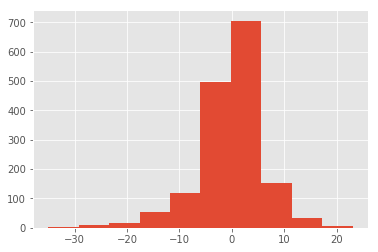

In [48]:
sizes = dna.groupby('route').size().to_frame()
dna['diff'].hist()

In [54]:
def label_diff(diff):
    if diff == 0:
        return '0'
    elif 0 < diff and diff <= 5:
        return '1 to 5'
    elif 6 < diff and diff <= 10:
        return '6 to 10'
    elif diff > 10:
        return 'higher than 10'
    elif -5 <= diff and diff < 0:
        return '-5 to -1'
    elif -10 <= diff and diff < -5:
        return '-10 to -6'
    elif diff < -10:
        return 'lower than -10'
dna['diff_label'] = dna['diff'].map(label_diff)

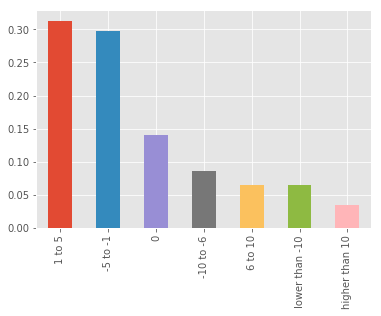

In [55]:
dna['diff_label'].value_counts(normalize=True).plot.bar()